#### formula

In [27]:
from torch import sin, randn_like

def real_formula(x):
    return sin(x) / x - x / 10

def noise_formula(x, form=real_formula, noise_scale=0.01):
    y = form(x)
    noise = randn_like(y) * noise_scale
    return y + noise

#### chart

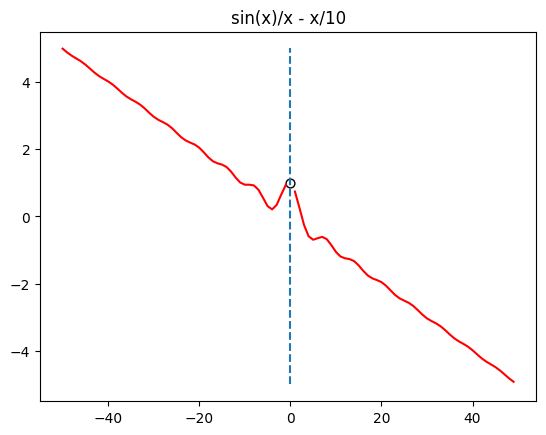

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from torch import arange as trange

x_negative = trange(-50, 0)
x_positive = trange(1, 50)

def y_calc(x):
    return [real_formula(value) for value in x]

y_1 = y_calc(x_negative)
y_2 = y_calc(x_positive)

plt.scatter(0, 1, color='white', marker='o', edgecolors='black', s=40)
plt.plot(x_negative, y_1, c='r')
plt.plot(x_positive, y_2, c='r')
plt.plot(np.zeros(11), np.arange(-5, 6), '--')
plt.title('sin(x)/x - x/10')
plt.show()

#### datasets

In [29]:
batch_size = 200

In [30]:
from torch import FloatTensor, cat

def generate_data(func, n_samples):
    x = FloatTensor(n_samples).uniform_(-1000, 1000)
    x = x[x != 0]

    extra_samples = FloatTensor(n_samples - len(x)).uniform_(-1000000, 1000000)

    x = cat([x, extra_samples])

    y = func(x)[:, None]
    x = x[:, None]

    points = [(x_i, y_i) for x_i, y_i in zip(x, y)]

    return points

real = generate_data(real_formula, 1200)
noise = generate_data(noise_formula, 100)

#### Generator

In [31]:
import torch.nn as nn
from torch import tensor

class Generator(nn.Module):
    def __init__(self, hid_1, in_=1, out_=2):
        super().__init__()
        hid_2 = int(hid_1 * 2)
        hid_4 = int(hid_1 * 4)

        fc1 = nn.Linear(in_, hid_1)
        fc2 = nn.Linear(hid_1, hid_2)
        fc3 = nn.Linear(hid_2, hid_4)
        fc4 = nn.Linear(hid_4, out_)

        relu = nn.ReLU()

        self.model = nn.Sequential(
            fc1, relu,
            fc2, relu,
            fc3, relu,
            fc4
        )

    def forward(self, z):

        point = self.model(z)

        x = point[:, 0].clone().detach()
        y = point[:, 1].clone().detach()

        return x[:, None], y[:, None]

#### Discriminator

In [32]:
class Discriminator(nn.Module):
    def __init__(self, hid_1, in_=1, out_=1):
        super().__init__()
        hid_2 = int(hid_1/2)

        fc1 = nn.Linear(in_, hid_1)
        fc2 = nn.Linear(hid_1, hid_2)
        fc3 = nn.Linear(hid_2, out_)

        l_relu = nn.LeakyReLU(0.2, inplace=True)
        sigmoid = nn.Sigmoid()

        nn.init.uniform_(fc1.weight, -0.005, 0.005)
        fc1.bias.data.zero_()

        self.model = nn.Sequential(
            fc1, l_relu,
            fc2, l_relu,
            fc3, sigmoid
        )

    def forward(self, x):
        batch = x.size(0)
        x = x.view(batch, -1)

        return self.model(x)

#### MyDataset

In [33]:
from torch.utils.data import Dataset, DataLoader

# concatenate data
class MyDataset(Dataset):

    def __init__(self, real, noise):
        self.real = real
        self.noise = noise

    def __getitem__(self, idx):
        if idx < len(self.real):
            return self.real[idx]
        else:
            return self.noise[idx - len(self.real)]

    def __len__(self):
        return len(self.real) + len(self.noise)

dataset = MyDataset(real, noise)
print(dataset[0])

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

test = iter(loader)
next(test)

(tensor([554.9006]), tensor([-55.4884]))


[tensor([[-2.9870e+02],
         [-2.6852e+02],
         [-8.5453e+02],
         [ 1.2213e+02],
         [-3.4268e+02],
         [ 1.7225e+02],
         [-3.2928e+02],
         [ 6.8646e+02],
         [ 1.8093e+02],
         [-3.7456e+01],
         [-3.2173e+02],
         [-9.8644e+02],
         [ 4.9718e+02],
         [-9.8746e+02],
         [-5.7823e+02],
         [ 5.5978e+02],
         [-6.0242e+02],
         [-1.8099e+02],
         [ 1.3577e+02],
         [-1.1348e+01],
         [-7.2478e+02],
         [ 4.2333e+02],
         [-6.1160e+02],
         [-6.9049e+02],
         [-2.7968e+01],
         [-7.8910e+02],
         [ 7.5411e+02],
         [-7.4348e+02],
         [ 9.4429e+02],
         [-3.0912e+01],
         [ 7.1739e+02],
         [-8.4739e+02],
         [ 4.3911e+02],
         [-9.3070e+02],
         [-3.4500e+01],
         [-7.3460e+02],
         [-8.1703e+02],
         [-1.1135e+02],
         [-2.4444e+02],
         [-2.8224e+02],
         [ 5.2782e+02],
         [-1.059

In [34]:
gen = Generator(hid_1=256)
disc = Discriminator(hid_1=256)

#### Optimizers

In [35]:
from torch.optim import Adam
opt_gen = Adam(gen.parameters(), lr=0.0001)
opt_disc = Adam(disc.parameters(), lr=0.0001)

#### learning

In [36]:
# Оптимизаторы и критерии
from torch import ones_like, zeros_like

criterion = nn.BCELoss()

disc_losses = []
gen_losses = []

epochs = 20

for epoch in range(epochs):
    loss_disc, loss_gen = 0.0, 0.0
    for i, (x_real, y_real) in enumerate(loader):

        # fakes
        x_fake, y_fake = gen(x_real)

        # combine
        x_combined = cat([x_real, x_fake], dim=0)
        y_combined = cat([y_real, y_fake], dim=0)

        disc_out = disc(x_combined)
        loss_disc = criterion(disc_out, ones_like(disc_out))
        disc_losses.append(loss_disc.detach().item())

        loss_disc.backward()
        opt_disc.step()

        # Обучение Генератора
        x_pred, y_pred = gen(x_real)
        disc_fake = disc(cat([x_pred, y_pred], dim=0)).unsqueeze(1)

        loss_gen = criterion(disc_fake, ones_like(disc_fake))

        gen_losses.append(loss_gen.detach().item())
        loss_gen.backward()
        opt_gen.step()

    print(f"Epoch {epoch}, Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}")

Epoch 0, Loss D: 0.6005, Loss G: 0.7245
Epoch 1, Loss D: 0.5278, Loss G: 0.7115
Epoch 2, Loss D: 0.4402, Loss G: 0.6900
Epoch 3, Loss D: 0.3916, Loss G: 0.6671
Epoch 4, Loss D: 0.3958, Loss G: 0.6507
Epoch 5, Loss D: 0.3749, Loss G: 0.6257
Epoch 6, Loss D: 0.3563, Loss G: 0.6107
Epoch 7, Loss D: 0.3261, Loss G: 0.5695
Epoch 8, Loss D: 0.3243, Loss G: 0.5593
Epoch 9, Loss D: 0.3202, Loss G: 0.5135
Epoch 10, Loss D: 0.2818, Loss G: 0.4633
Epoch 11, Loss D: 0.2749, Loss G: 0.4467
Epoch 12, Loss D: 0.2228, Loss G: 0.3736
Epoch 13, Loss D: 0.2243, Loss G: 0.3500
Epoch 14, Loss D: 0.1890, Loss G: 0.3081
Epoch 15, Loss D: 0.1803, Loss G: 0.2908
Epoch 16, Loss D: 0.1696, Loss G: 0.2646
Epoch 17, Loss D: 0.1675, Loss G: 0.2337
Epoch 18, Loss D: 0.1477, Loss G: 0.2050
Epoch 19, Loss D: 0.1248, Loss G: 0.1855


[0.7519076466560364, 0.7169709801673889, 0.6911531090736389, 0.6643510460853577, 0.6461107730865479, 0.6196040511131287, 0.6005129814147949, 0.5896033644676208, 0.5769262909889221, 0.5600796341896057, 0.5406500101089478, 0.5326517224311829, 0.5259687304496765, 0.5277714729309082, 0.5092734694480896, 0.4993377923965454, 0.4860425293445587, 0.4818013310432434, 0.47872257232666016, 0.45707592368125916, 0.44021689891815186, 0.4531725347042084, 0.4434346854686737, 0.442931205034256, 0.43525177240371704, 0.4265764653682709, 0.43536341190338135, 0.39161568880081177, 0.41333115100860596, 0.3959178030490875, 0.40386977791786194, 0.4095771014690399, 0.4047389328479767, 0.39370521903038025, 0.3958161473274231, 0.38460808992385864, 0.3756113052368164, 0.3814893960952759, 0.38316628336906433, 0.3673108220100403, 0.3710229992866516, 0.374878466129303, 0.3543177545070648, 0.3675509989261627, 0.34426039457321167, 0.35982292890548706, 0.3491230309009552, 0.35301825404167175, 0.35625144839286804, 0.3397

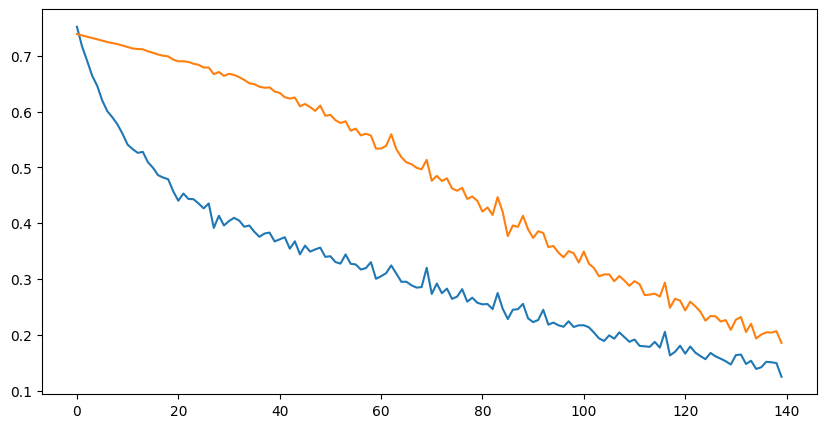

In [40]:
plt.figure(figsize=(10, 5))
print(disc_losses)
plt.plot(range(len(disc_losses)), disc_losses, label='disc loss')
plt.plot(range(len(gen_losses)), gen_losses, label='gen loss')
plt.show()